In [1]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
training = False
#check if cuda is available
torch.cuda.is_available()

True

In [3]:
# Data
n_tracks = 5  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 100

# Training
batch_size = 32
latent_dim = 128
n_steps = 8000

# Sampling
sample_interval = 100  # interval to run the sampler (in step)
n_samples = 4

In [4]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)

## Data Preparation

In [5]:
if training==False:
    dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
    id_list = []
    for path in os.listdir("data/lpd_5/amg"):
        filepath = os.path.join("data/lpd_5/amg", path)
        if os.path.isfile(filepath):
            with open(filepath) as f:
                id_list.extend([line.rstrip() for line in f])
    id_list = list(set(id_list))
    
   # print(id_list)

In [6]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

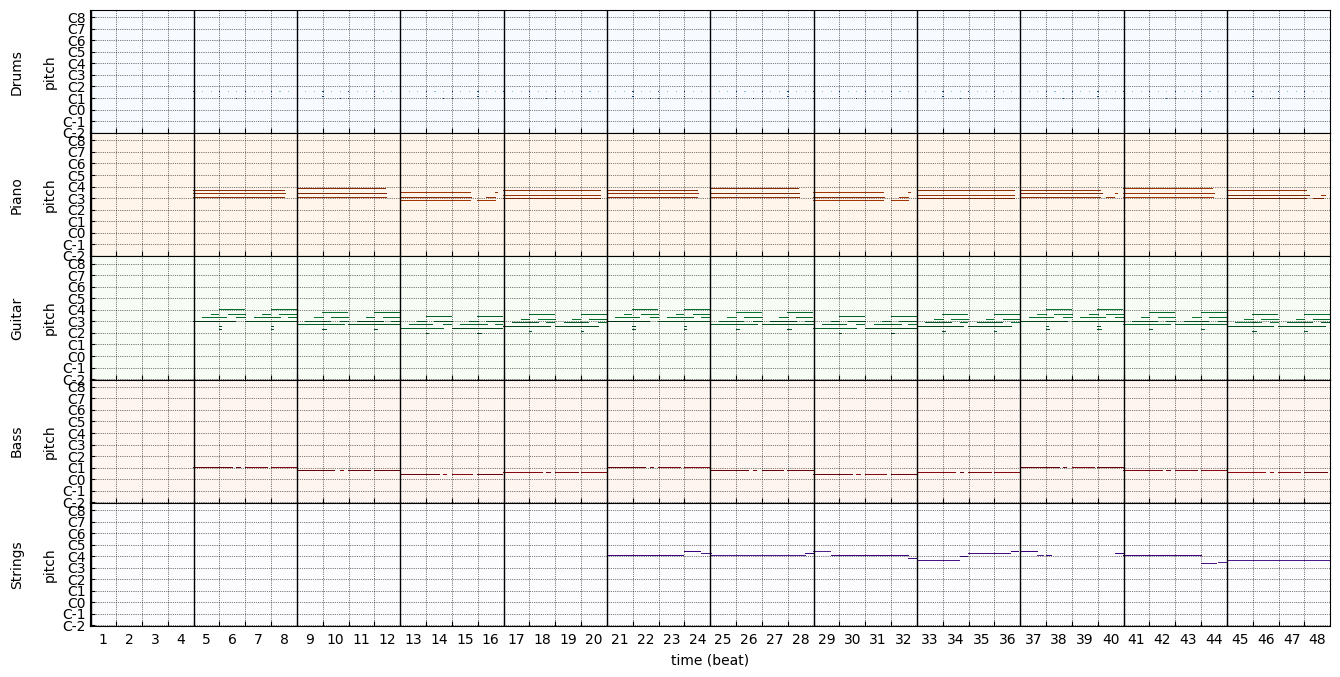

In [7]:
if training==False:
    song_dir = dataset_root / msd_id_to_dirs('TREVDFX128E07859E0') # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    multitrack.trim(end=12 * 96)
    axs = multitrack.plot()
    plt.gcf().set_size_inches((16, 8))
    for ax in axs:
        for x in range(96, 12 * 96, 96):     
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.show()

In [8]:
data = []
# Iterate over all the songs in the ID list
for msd_id in tqdm(id_list):
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root / msd_id_to_dirs(msd_id)
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}")

100%|██████████| 7323/7323 [04:48<00:00, 25.40it/s]


Successfully collect 26154 samples from 7323 songs
Data shape : (26154, 5, 64, 72)


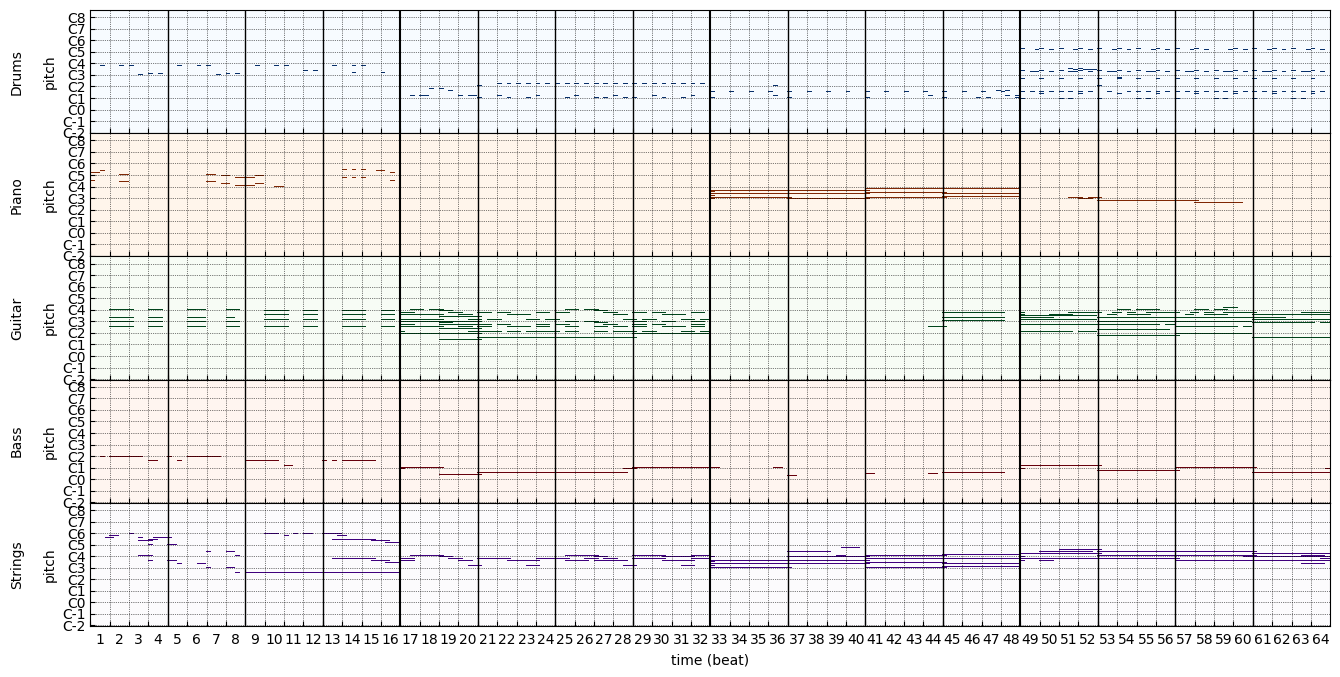

In [9]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [10]:
data = torch.tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## Define the VAE model

In [11]:
import torch
from torch import nn
from torch.nn import functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        # 根据您的数据调整卷积层的参数
        self.conv1 = nn.Conv2d(5, 32, kernel_size=4, stride=2, padding=1) # 输出形状: [32, 32, 36]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # 输出形状: [64, 16, 18]
        self.fc_mu = nn.Linear(64 * 16 * 18, latent_dim)
        self.fc_logvar = nn.Linear(64 * 16 * 18, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # 展平
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 16 * 18)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 5, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        z = self.fc(z)
        z = z.view(z.size(0), 64, 16, 18) # 重塑
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z)) # 使用sigmoid确保输出在[0, 1]范围内
        return z

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [12]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='mean')  # 使用平均值
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD                          

In [13]:
log_interval = 10
# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
latent_dim = 64  # 潜在空间的维度
vae = VAE(latent_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(100):
    for batch_idx, data in enumerate(data_loader):
        data = data[0].to(device)  # data[0] 因为 DataLoader 返回的是一个包含一个张量的列表

        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        
    # 每个 epoch 结束时打印信息
    print(f'==> Epoch: {epoch}, Average Loss: {loss.item() / len(data_loader.dataset):.8f}')


Using device: cuda
==> Epoch: 0, Average Loss: 0.00000393
==> Epoch: 1, Average Loss: 0.00000373
==> Epoch: 2, Average Loss: 0.00000389
==> Epoch: 3, Average Loss: 0.00000399
==> Epoch: 4, Average Loss: 0.00000401
==> Epoch: 5, Average Loss: 0.00000407
==> Epoch: 6, Average Loss: 0.00000419
==> Epoch: 7, Average Loss: 0.00000388
==> Epoch: 8, Average Loss: 0.00000374
==> Epoch: 9, Average Loss: 0.00000399
==> Epoch: 10, Average Loss: 0.00000400
==> Epoch: 11, Average Loss: 0.00000378
==> Epoch: 12, Average Loss: 0.00000380
==> Epoch: 13, Average Loss: 0.00000369
==> Epoch: 14, Average Loss: 0.00000395
==> Epoch: 15, Average Loss: 0.00000337
==> Epoch: 16, Average Loss: 0.00000376
==> Epoch: 17, Average Loss: 0.00000345
==> Epoch: 18, Average Loss: 0.00000397
==> Epoch: 19, Average Loss: 0.00000378
==> Epoch: 20, Average Loss: 0.00000380
==> Epoch: 21, Average Loss: 0.00000338
==> Epoch: 22, Average Loss: 0.00000381
==> Epoch: 23, Average Loss: 0.00000425
==> Epoch: 24, Average Loss: 0.

In [14]:
def sample_latent_space(vae, device, n_samples=1, latent_dim=64):
    """从潜在空间中采样并解码生成音乐"""
    with torch.no_grad():
        # 从标准正态分布中采样
        z = torch.randn(n_samples, latent_dim).to(device)
        # 解码样本
        generated_music = vae.decoder(z)
    return generated_music

# 生成样本
vae.eval()
generated_music = sample_latent_space(vae, device, n_samples=4, latent_dim=latent_dim)

# 将生成的音乐数据转换为二值格式
generated_music = torch.sigmoid(generated_music).cpu().numpy()
binary_music = np.where(generated_music > 0.5, 1, 0)

# 创建pypianoroll.Track对象并保存为MIDI文件
for i in range(binary_music.shape[0]):
    track = Track(pianoroll=binary_music[i, 0, :, :], program=0, is_drum=False, name='Piano')
    multitrack = Multitrack(tracks=[track], tempo=tempo_array, resolution=beat_resolution)
    pypianoroll.write(multitrack, f'generated_VAE_{i}.mid')




AttributeError: 'str' object has no attribute 'tempo'